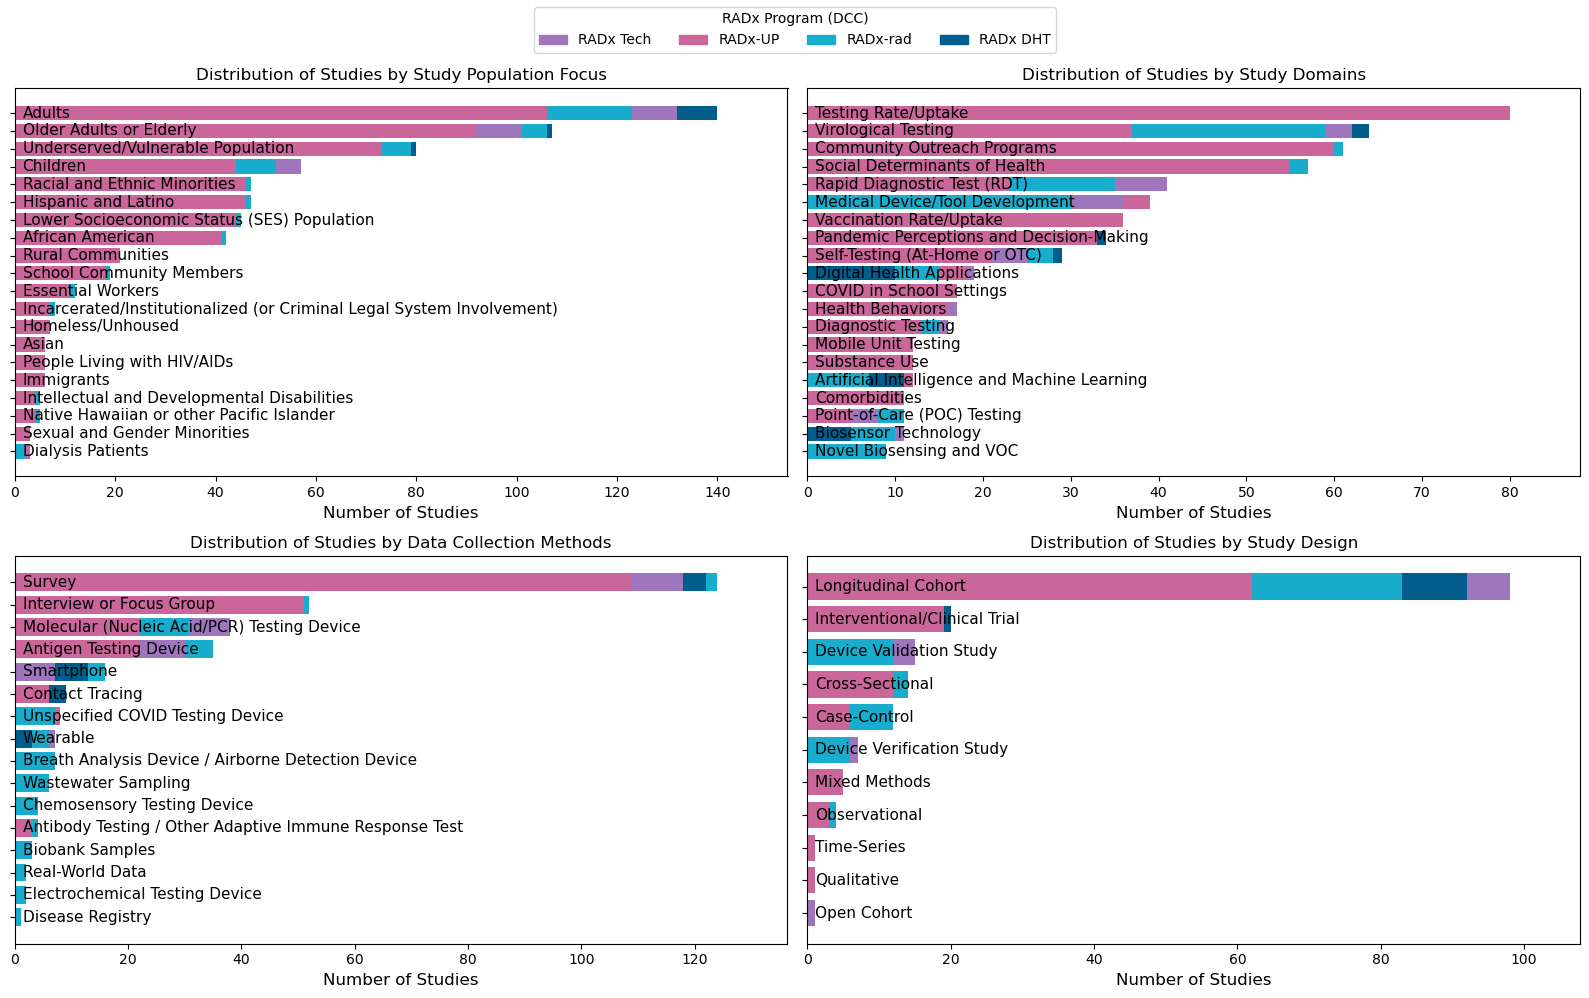

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches  # For custom legend

# Load the data
file_path = "StudyExplorerResults.csv"  # Replace with your file path
data = pd.read_csv(file_path, encoding="latin1")

# Process the data
data["Study Population Focus"] = data["Study Population Focus"].str.split("; ")
data["Study Domain"] = data["Study Domain"].str.split("; ")
data["Data Collection Method"] = data["Data Collection Method"].str.split("; ")

# Explode columns to have one value per row for analysis
exploded_population_focus = data.explode("Study Population Focus")
exploded_study_domain = data.explode("Study Domain")
exploded_data_collection = data.explode("Data Collection Method")

# Count occurrences for each category in each field
top_population_focus = exploded_population_focus["Study Population Focus"].value_counts().head(20)
top_study_domain = exploded_study_domain["Study Domain"].value_counts().head(20)
top_data_collection = exploded_data_collection["Data Collection Method"].value_counts().head(20)

# Prepare dataframes for stacked bar chart
def prepare_stacked_data(column_name, top_categories):
    exploded = data.explode(column_name)
    filtered = exploded[exploded[column_name].isin(top_categories.index)]
    return filtered.groupby([column_name, "RADx Data Program"]).size().unstack(fill_value=0)

stacked_population_focus = prepare_stacked_data("Study Population Focus", top_population_focus)
stacked_study_domain = prepare_stacked_data("Study Domain", top_study_domain)
stacked_data_collection = prepare_stacked_data("Data Collection Method", top_data_collection)
stacked_study_design = data.groupby(["Study Design", "RADx Data Program"]).size().unstack(fill_value=0)

# Sort data
def sort_stacked_data(data):
    # Keep the columns in the original order (since we will sort per row)
    data = data.loc[data.sum(axis=1).sort_values(ascending=True).index]
    return data

sorted_population_focus = sort_stacked_data(stacked_population_focus)
sorted_study_domain = sort_stacked_data(stacked_study_domain)
sorted_data_collection = sort_stacked_data(stacked_data_collection)
sorted_study_design = sort_stacked_data(stacked_study_design)

# Define colors for RADx programs
radx_colors = {
    "RADx Tech": "#9f75bb", 
    "RADx-UP": "#ca6699",   
    "RADx-rad": "#18accd",   
    "RADx DHT": "#005d8c", 
}

# Updated plotting function
def plot_stacked_bars_horizontal_ordered(data_list, titles, xlabel, colors=None, output_file="stacked_bars_horizontal_labels.png", max_label_length=48):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()
    
    for i, data in enumerate(data_list):
        ax = axes[i]
        y_positions = range(len(data))
        y_labels = data.index
        bar_height = 0.8
        
        # Set maximum value for x-axis limit
        max_value = data.sum(axis=1).max() * 1.1  # Add some padding
        
        for y_pos, (index, row) in zip(y_positions, data.iterrows()):
            # Sort the counts for this row in decreasing order
            row_sorted = row.sort_values(ascending=False)
            programs = row_sorted.index
            counts = row_sorted.values
            left = 0
            for program, count in zip(programs, counts):
                if count > 0:
                    ax.barh(y_pos, count, left=left, height=bar_height, color=colors.get(program, "#333333"))
                    left += count
        
        # Set y-axis
        ax.set_yticks(y_positions)
        ax.set_yticklabels([])
        ax.set_xlim(0, max_value)
        
        # Add y-axis labels next to the bars
        for tick, label in zip(y_positions, y_labels):
            ax.text(
                max_value * 0.01, tick, label,
                ha='left', va='center', fontsize=11, linespacing=1.2, color="black"
            )
        ax.set_title(titles[i], fontsize=12)
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel("")
    
    # Create custom legend
    legend_handles = []
    for program, color in colors.items():
        patch = mpatches.Patch(color=color, label=program)
        legend_handles.append(patch)
    fig.legend(handles=legend_handles, title="RADx Program (DCC)", loc='upper center', ncol=4, fontsize=10)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(output_file, format="png", dpi=300)
    plt.show()

# Data and titles for the grid
data_list = [
    sorted_population_focus,
    sorted_study_domain,
    sorted_data_collection,
    sorted_study_design
]

titles = [
    "Distribution of Studies by Study Population Focus",
    "Distribution of Studies by Study Domains",
    "Distribution of Studies by Data Collection Methods",
    "Distribution of Studies by Study Design"
]

xlabel = "Number of Studies"

# Plot all charts with horizontal bars and save to a file
plot_stacked_bars_horizontal_ordered(
    data_list,
    titles,
    xlabel=xlabel,
    colors=radx_colors,
    output_file="stacked_bars_horizontal_labels.png"
)
